<a href="https://colab.research.google.com/github/connorgilmoreut/mis382n/blob/main/FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <p style="text-align: center;">Analytics for Unstructured Data</p>
## <p style="text-align: center;">Group Assignment #1</p>
### <p style="text-align: center;">Authors: Conoly Cravens, JT Flume, Connor Gilmore, Jessie Lee, Garrett Sooter</p>

### Webscraping
* Forum Link: https://forums.edmunds.com/discussion/50806/general/x/car-subscription-vs-lease-vs-purchase'
* Scrape output: CSV with date and message
* Scrape ~ 5000 posts

In [1]:
# Use this code if using Colab to run Selenium

# Make sure to go to Runtime -> Change runtime and set GPU as hardware accelerator

# !kill -9 -1 # Use this line to delete this VM and start a new one. 
# The above line deletes all files and folders from the current VM and allocates a new one.

#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver 
#WebDriver is a browser automation framework that works with open source APIs. 
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

     |████████████████████████████████| 904 kB 5.6 MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.4 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.laun

In [2]:
## HELPFUL TO RESET
wd = webdriver.Chrome('chromedriver',options=chrome_options)
wd.get("https://www.example.com")

In [3]:
wd.get('https://forums.edmunds.com/discussion/50806/general/x/car-subscription-vs-lease-vs-purchase')

In [4]:
# Get time stamp and comments from the forum
allComment = []
allTime = []
for i in range(300, 436):
    wd.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'+str(i))
    user_message = wd.find_elements_by_class_name("Comment")

    for element in user_message:
        comment_element = element.find_element_by_class_name("Message")
        time_element = element.find_element_by_tag_name("time")
        allComment.append(comment_element.text)
        allTime.append(time_element.get_attribute('title'))

In [6]:
#Explort to a csv file 'luxcar'
import pandas as pd

df = pd.DataFrame(columns=['date', 'comment'])
df['date'] = allTime
df['comment'] = allComment
df.to_csv("luxcar.csv")

from google.colab import files
files.download("luxcar.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Prepare & Clean CSV File

In [7]:
import spacy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

nlp=spacy.load('en_core_web_sm')
#Read in CSV
luxcar=pd.read_csv('luxcar.csv')

Saving luxcar.csv to luxcar (1).csv


In [8]:
luxcar.fillna('',inplace=True)
luxcar=luxcar.drop('Unnamed: 0',1)

In [9]:
#Tokenize comment
luxcar['token']=luxcar['comment'].map(lambda x:nlp(x))

### Task A [Test Zipf's Law]

In [10]:
# STEP 1: create frequency dictionary for ALL words (including stopwords)
voc=dict()
for row in range(len(luxcar)):
    text=luxcar['token'].iloc[row]
    for word in text:
        if word.is_punct:
            continue
        
        if word.text.lower() in voc:
            voc[word.text.lower()]+=1
        else:
            voc[word.text.lower()]=1

In [11]:
# STEP 2: create dataframe from dictionary
word_count = pd.DataFrame.from_dict(voc, orient = 'index')
word_count.columns=['count']
word_sort=word_count.sort_values(by='count',ascending=False)

In [12]:
# STEP 3: Sort counts and add rank
word_rank=word_sort.copy()
word_rank['word']=word_rank.index
word_rank=word_rank.reset_index()
word_rank=word_rank.drop('index',1)
word_rank['rank']=word_rank.index+1
col=word_rank.columns.tolist()
word_rank=word_rank[['word','count','rank']]

Text(0, 0.5, 'Word Count')

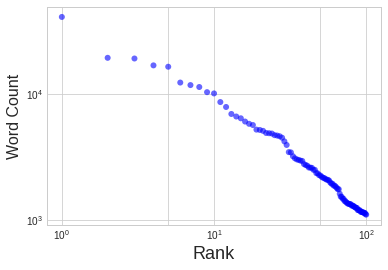

In [13]:
# Step 4: Plot Zipf's plot for raw word counts
import matplotlib
from matplotlib import pyplot as plt

plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.gca()
ax.scatter(word_rank['rank'][:100] ,word_rank['count'][:100] , 
           c='blue', 
           alpha=.6, 
           edgecolors='none')
ax.set_xscale('log')
plt.xticks([1e0,0.5e1,1e1,0.5e2,1e2])
ax.set_yscale('log')
ax.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.xlabel('Rank', fontsize=18)
plt.ylabel('Word Count', fontsize=16)

As you can see from Zipf's plot below, there is a linear relationship between word counts and rank in log scale, hence this data supports Zipf's Law.

### Task B [Find Top 10 Brands]
* First, we replaced all models with their corresponding brand in a new column called 'cov_brand'
* Calculated top 10 mentioned brands with their frequency count

In [15]:
# Get the raw count of each brand in comments, counting for multiple mentions in one comments

from google.colab import files
uploaded = files.upload()

#Please note: we cleaned the provided car models and brands CSV so that all models had the same format / spelling
## This fixed things like mercedes vs mercedes benz vs mercedes-benz
brand_model = pd.read_csv('car models and brands_CLEAN.csv')

#Created dictionary
modelToBrand = dict(zip(brand_model.Model, brand_model.Brand))
#Deleted 'rows' that were not a model / brand connection
del modelToBrand['cars']
del  modelToBrand['problems']
del  modelToBrand['seats']
del modelToBrand['sedans']

Saving car models and brands_CLEAN.csv to car models and brands_CLEAN.csv


In [16]:
#Replace model names with brand names
def cov_brand(comment):
    new_comment = []
    for word in comment:
        if word.text.lower() in modelToBrand.keys():
            word=modelToBrand[word.text.lower()]
            new_comment.append(word)
        else: 
            word = word.text.lower()
            new_comment.append(word)
        
    return(' '.join(new_comment))

luxcar['cov_brand']=luxcar['token'].map(cov_brand)
luxcar['cov_brand']=luxcar['cov_brand'].map(lambda x:nlp(x))

In [17]:
#Create a dictionary where brand frequencies are counted
brandCount = dict()

for row in range(len(luxcar)):
    text=luxcar['cov_brand'].iloc[row]
    for word in text:
        if word.is_punct:
            continue
        if word.text in modelToBrand.values():
            if word.text in brandCount:
                brandCount[word.text]+=1
            else:
                brandCount[word.text]=1

In [18]:
#Put dictionary into dataframe
brand_count=pd.DataFrame.from_dict(brandCount,orient='index')
brand_count.columns=['count']
brand_sort=brand_count.sort_values(by='count',ascending=False)

In [19]:
#Get the top 10 brand names by raw counts
top10=brand_sort[:10]
top10Name=top10.index
top10

,count
bmw,3734
audi,3500
acura,1846
honda,1307
infiniti,998
volkswagen,755
toyota,611
cadillac,570
hyundai,519
mercedes,490


### Task C [Lift Ratios between Top 10 Brands]
##### First, we calculated the raw counts for each of the top 10 brands (counting each brand a maximum of ONCE per comment).

In [20]:
# Step 1: Calculate raw counts for each of the 10 top brands
commentbrand = []


for row in range(len(luxcar)):
    text=luxcar['cov_brand'].iloc[row]
    brandset = set()
    for word in text:
        if word.is_punct:
            continue
        if word.text in top10Name:
            brandset.add(word.text)
    if len(brandset) > 0 :
        commentbrand.append(brandset)

In [21]:
#Creat a set to count occurance
commentbrand=list(commentbrand)
len(commentbrand)

for i in range(len(commentbrand)):
    commentbrand[i]=list(commentbrand[i])

#Blank count table
count_table=pd.DataFrame(np.zeros((10,10)))
count_table.columns=top10Name
count_table.index=top10Name

In [22]:
#Raw counts

for i in range(len(top10Name)):
    for sets in commentbrand:
        for item in sets:
            if item==top10Name[i]:
                count_table.iloc[i,i]+=1
                for j in range(i+1,len(top10Name)):
                    for item in sets:
                        if item==top10Name[j]:
                            count_table.iloc[i,j]+=1
        


In [23]:
count_table

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,cadillac,hyundai,mercedes
bmw,1815.0,582.0,290.0,195.0,222.0,120.0,126.0,150.0,83.0,228.0
audi,0.0,1272.0,335.0,207.0,223.0,185.0,111.0,158.0,86.0,189.0
acura,0.0,0.0,838.0,268.0,191.0,61.0,78.0,90.0,57.0,106.0
honda,0.0,0.0,0.0,674.0,73.0,81.0,110.0,45.0,55.0,60.0
infiniti,0.0,0.0,0.0,0.0,461.0,34.0,47.0,67.0,40.0,77.0
volkswagen,0.0,0.0,0.0,0.0,0.0,386.0,48.0,21.0,35.0,28.0
toyota,0.0,0.0,0.0,0.0,0.0,0.0,378.0,34.0,46.0,35.0
cadillac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,304.0,26.0,80.0
hyundai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.0,25.0
mercedes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,321.0


##### Step 2: calculated the paired lift between the 10 top brands

In [43]:
#Calculate paired lift

lift_table=pd.DataFrame(np.zeros((10,10)))
lift_table.columns=top10Name
lift_table.index=top10Name

for i in range(len(top10Name)):
    lift_table.iloc[i,i]=''
    for j in range(i+1,len(top10Name)):
        lift_table.iloc[i,j]=count_table.iloc[i,j]/count_table.iloc[i,i]/(count_table.iloc[j,j]/6783)
        lift_table.iloc[j, i] = ''
lift_table

,bmw,audi,acura,honda,infiniti,volkswagen,toyota,cadillac,hyundai,mercedes
bmw,,1.70994,1.2933,1.08123,1.79969,1.16182,1.24573,1.84401,1.14039,2.65445
audi,,,2.13175,1.63774,2.57952,2.55575,1.56591,2.77152,1.68603,3.13972
acura,,,,3.21849,3.35359,1.27915,1.67025,2.39633,1.69623,2.67287
honda,,,,,1.59362,2.11183,2.92862,1.48971,2.03496,1.88108
infiniti,,,,,,1.29602,1.82948,3.24281,2.16377,3.52945
volkswagen,,,,,,,2.23143,1.21389,2.26117,1.53281
toyota,,,,,,,,2.00694,3.03472,1.95656
cadillac,,,,,,,,,2.13281,5.56075
hyundai,,,,,,,,,,1.94217
mercedes,,,,,,,,,,


### Task D [MDS Map]

##### Library Imports

In [25]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [26]:
import matplotlib
from matplotlib import pyplot as plt

In [27]:
from matplotlib.pyplot import figure

In [28]:
import pickle as pkl

In [29]:
from sklearn.metrics import pairwise_distances

In [30]:
from sklearn.manifold import MDS

### Run MDS

#### Compute Dissimilarity 

In [31]:
lift_data = lift_table

In [32]:
for i in range(len(lift_data)):
    lift_data.iloc[i,i] = 0
    for j in range(i+1,len(lift_data)):
        lift_data.iloc[i,j] = 1/lift_data.iloc[i,j]

In [33]:
lift_df = np.triu(lift_data) + np.triu(lift_data,1).T

##### Run MDS

In [37]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=2)
out = model.fit_transform(lift_df)

In [38]:
brands = lift_data.columns

##### Plot

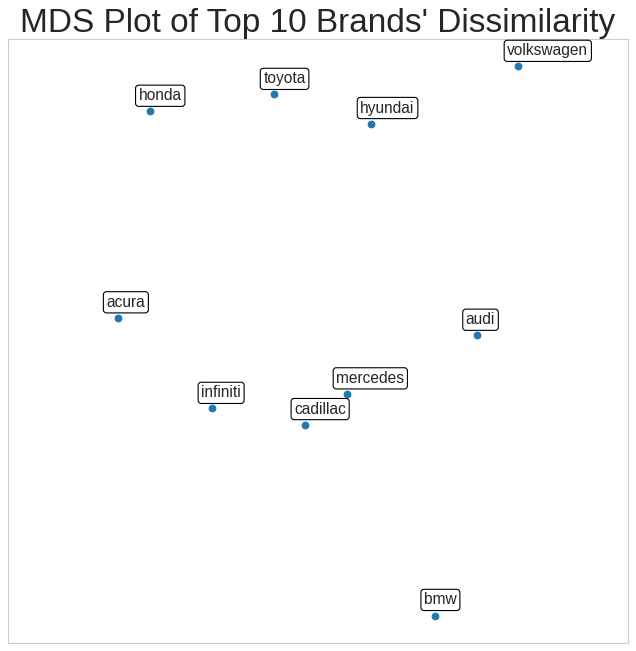

In [39]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = plt.gca()
ax.scatter(out[:, 0], out[:, 1])
plt.axis('equal')
plt.title("MDS Plot of Top 10 Brands' Dissimilarity", fontsize=30)
ax.set_xticks([])
ax.set_yticks([])
for label, x, y in zip(brands, out[:, 0], out[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), 
        xytext = (-10, 10),
        textcoords = 'offset points',
        fontsize=14,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    )
plt.show();

### Task E [MDS Map Insights]

Through mining discussion forum on Edmunds on the recent 6000+ comments, we extract information about co-mentions as paired brand lift values to understand brands association. Then we generate a 10X10 brand pair Dissimilarity matrix by inversing lift values and performed multidimensional scaling (MDS) to reduce the dimension of the Dissimilarity matrix from 10 to 2. 

The MDS plot clearly separates the perceived groups of ‘luxury cars’ (lower left corner) vs economy cars (upper right corner), where it’s understandable when people are considering potential ‘switch’, they are likely to consider the cars in their ‘target group’. Since it’s a discussion of about intro level luxury car, this can be interpreted as people tend to either target the premium version of the economy brands, such as a loaded Honda or a loaded Toyota sedan, versus the more entry level luxury brands, such as a BMW or an Audi model of their interest. As a result, marketing campaign should strategize their effort to attract the potential customers who target the ‘nearby’ brands in the same ‘group’ of the MDS plot. 

To gain more insights, we can in the future incorporate some frequently mentioned features of people’s interest to increase the dimensionality of the Lift matrix. This may reveal more consumer interest and priorities for brand choosing decision and help market campaign to make a more informed campaign decision.

### Task F [Attribute Analysis]
##### The 5 most frequently mentioned atributes or features of cars:

In [ ]:
# STEP 1: create a dictionary of attributes where the key is the word and value is the number of time it appears
attribute_count=dict()

for row in range(len(luxcar)):
    text=luxcar['cov_brand'].iloc[row]
    for word in text:
        #Ignore punctuation
        if word.is_punct:
            continue
        #Ignore stop words
        elif word.is_stop:
            continue
        #Ignore brands
        elif word.text in modelToBrand.values():
            continue
        #Tally all other word counts
        elif word.text in attribute_count:
            attribute_count[word.text]+=1
        else:
            attribute_count[word.text]=1

In [ ]:
attribute_sort = pd.DataFrame.from_dict(attribute_count, orient = 'index')
attribute_sort.columns=['count']
attribute_sort = attribute_sort.sort_values(by='count',ascending=False)

In [ ]:
# To determine the top 5 attributes, we exported to a CSV and chose the top 5 features (note: values such as $ or \n were excluded)
#attribute_sort.to_csv('attributes_sorted.csv', index=True)

In [ ]:
attributes_list = ('price', 'sport', 'engine', 'awd', 'performance')

In [ ]:
attribute_sort[attribute_sort.index.isin(attributes_list)]

##### Which attributes are most strongly associated with which of the top-10 brands?
To answer this, we calculated lift ratios for the top-10 brands and these attributes. See results below.

In [ ]:
#Create list of attributes for each column
attributes = []


for row in range(len(luxcar)):
    text=luxcar['cov_brand'].iloc[row]
    attributelist = list()
    for word in text:
        if word.is_punct:
            continue
        if word.text in attributes_list:
            attributelist.append(word.text)
        if word.text in top10Name:
            attributelist.append(word.text)
    if len(attributelist) > 0 :
        attributes.append(attributelist)


In [ ]:
def count_brand_atb_pair(brand_a, attribute):
    count = 0
    for i in range(len(attributes)):
        if (brand_a in attributes[i] and attribute in attributes[i]):
            count += 1
    return count

In [ ]:
def count_one_brand(brand):
    count = 0
    for i in range(len(attributes)):
        if (brand in attributes[i]):
            count += 1
    return count

In [ ]:
def count_attribute(attribute):
    count = 0
    for i in range(len(attributes)):
        if (attribute in attributes[i]):
            count += 1
    return count

In [ ]:
def get_lift_atb (brand_a, attribute):
    numerator = len(luxcar) * count_brand_atb_pair(brand_a, attribute)
    denominator = count_one_brand(brand_a) * count_attribute(attribute)
    return numerator / denominator 

In [ ]:
atb_list = []
brand_pairs = []
for i in range(len(top10Name)):
    brand_a = top10Name[i]
    i_list = []
    for j in range(len(attributes_list)):
        #get brand pair
        attribute = attributes_list[j]
        #calcualte lift 
        lift = get_lift_atb(brand_a, attribute)
        i_list.append(lift)
    atb_list.append(i_list)

Lift values:

In [ ]:
atb_lift = pd.DataFrame(atb_list)
atb_lift.index = top10Name
atb_lift.columns = attributes_list
atb_lift

Top brand associated with each attribute:

In [ ]:
atb_lift.idxmax()

### Task G [Attribute Advice]

When seeking more in-depth information on why certain brands are related to each other we looked for association in features of the vehicle brands. To do this we looked for the most frequently discussed features associated with the brands. We found the most common features are price, sport, awd, performance, and engine. Through this we calculated lift of these features with the brands. 

**Price**

We found that the brand most associated with price was Mercedes, followed by Hyundai and Cadillac. We hypothesized that this means that people are talking about value when they talk about these brands, particularly how Hyundai has good values for money.

**Sport**

When talking about sport Infinity, Audi, and BMW came out on top, being the brands most associated with sport performance. 

**AWD (all wheel drive)**

When talking about AWD Acura and Infinity came out on top surprising us. These are not brands usually associated with AWD like Audi is. 

**Engine**

When talking about the engine there where relatively similar lift values for most brands but Cadillac was lower in this aspect, likely because people care more how their Escalade feels in the back seat then how it is to drive.

**Performance**
When talking about performance Mercedes had the highest lift value 2.4 to the next highest, 2.0. Hyundai and Volkswagen underperformed in this aspect. 

**Conclusion**

Understanding which attributes people are talking about your brand can help you market products successfully. Are people talking about the features you thought they would? Or even the attributes you strategically hope they would? Are we competing against the brands we thought for these features? Business strategy (marketing + operations) can appropriately be analyzed.

### Task H [Aspirational Analysis]
To determine the most aspirational brand, we picked out the top aspirational words from our original attributes analysis (utilizing Zipf's Law). This list was: 'love', 'like', 'cool', 'good', 'better', 'want', 'nice', 'great'. For each of these aspirational words, we replaced it with the word 'aspirational' and calcualted lift values for all brands and the word aspirational.

As you can see, if we do not filter on count (number of comments a brands appears), we find that suzuki	is the most aspirational brands even though they are only in 6 comments. **WHY DOES LIFT MESS UP?**

In [ ]:
import collections
from collections import Counter

In [ ]:
# List of all unique brands
allbrands = list(collections.Counter(list(modelToBrand.values())).keys())

In [ ]:
asp_list = ('love', 'like', 'cool', 'good', 'better', 'want', 'nice', 'great')

In [ ]:
# REPLACE WORDS

def asp_brand(comment):
    new_comment = []
    for word in comment:
        if word.text.lower() in asp_list:
            word='aspiration'
            new_comment.append(word)
        else: 
            word = word.text.lower()
            new_comment.append(word)
        
    return(' '.join(new_comment))

luxcar['asp_brand']=luxcar['cov_brand'].map(asp_brand)

luxcar['asp_brand']=luxcar['asp_brand'].map(lambda x:nlp(x))

In [ ]:
# Create list of all brands + 'aspiration' 
asp = []

for row in range(len(luxcar)):
    text=luxcar['asp_brand'].iloc[row]
    attributelist = list()
    for word in text:
        if word.is_punct:
            continue
        if word.text == 'aspiration':
            attributelist.append(word.text)
        if word.text in allbrands:
            attributelist.append(word.text)
    if len(attributelist) > 0 :
        asp.append(attributelist)

In [ ]:
# Create count for each term
asp_count = []
for i in range(len(asp)):
    asp_count.append(Counter(asp[i]))

In [ ]:
# To calculate lift...

def count_brand_asp_pair(brand_a, word):
    count = 0
    for i in range(len(asp_count)):
        if (brand_a in asp_count[i].keys() and word in asp_count[i].keys()):
            count += 1
    return count

In [ ]:
def count_all_brand(brand):
    count = 0
    for i in range(len(asp_count)):
        if (brand in asp_count[i].keys()):
            count += 1
    return count

In [ ]:
def count_asp(word):
    count = 0
    for i in range(len(asp_count)):
        if (word in asp_count[i].keys()):
            count += 1
    return count

In [ ]:
def get_lift_asp (brand_a, word):
    numerator = len(asp_count) * count_brand_asp_pair(brand_a, word)
    denominator = count_all_brand(brand_a) * count_asp(word)
    return numerator / denominator 

In [ ]:
# Calculate lift value for every brands (with 'aspiration')

asp_list = []
brand_pairs = []
for i in range(len(allbrands)):
    brand_a = allbrands[i]
    i_list = []
    #get brand pair
    attribute = 'aspiration'
    brand_pair = [brand_a, attribute]
    brand_pairs.append(brand_pair)
    #calcualte lift 
    lift = get_lift_asp(brand_a, attribute)
    i_list.append(lift)
    asp_list.append(i_list)

In [ ]:
# Sort lift values in dataframe
asp_lift = pd.DataFrame(asp_list)
asp_lift.index = allbrands
asp_lift.columns = ['Lift Values']
asp_lift['count'] = asp_lift.index.map(lambda x:count_all_brand(x))
asp_lift.sort_values(by = 'Lift Values', ascending = False)

For this reason, we choose to only consider brands that were mentioned in at least 100 comments. We found that **Nissan was the most aspirational brand**, closely followed by Toyata and Subaru. The bottom brands include Lincoln, Buick, and Volvo.

In [ ]:
asp_lift_final = asp_lift[asp_lift['count'] >= 100]
asp_lift_final.sort_values(by = 'Lift Values', ascending = False)

Surprisingly the top aspirational brands are not very closely matched to the most mentioned in the luxury section of this forum. This is likely because of the long tail theory hiding the cars that are not a frequently discussed as luxury but floating the traditional German brands to the top. Because people do believe that brands like Nissan and Subaru are viewed as luxury but not as known for that there needs to be a marketing campaign to raise awareness of this. And for those brands charging a premium because they are ‘premium’ they should focus on maintaining quality and lowering price, because they cannot compete on luxury along anymore. 